In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilities import preprocessing
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, ArrayType, FloatType, IntegerType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import col, udf
from pyspark.ml.clustering import LDA

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
spark = SparkSession.builder \
           .appName('Tuning LDA Model') \
           .config("spark.jars", "mysql-connector-j-8.0.32.jar")\
           .config("spark.driver.memory", "6g") \
           .config("spark.executor.memory", "8g") \
           .getOrCreate()

In [3]:
data = spark.read \
            .format("jdbc") \
            .option("driver","com.mysql.cj.jdbc.Driver") \
            .option("url", "jdbc:mysql://web-database/Web") \
            .option("dbtable", "redditData") \
            .option("user", "root") \
            .option("password", "123") \
            .load() 
data.count()

3605

In [4]:
data = data.select('id', 'category', 'descriptions')
data = data.dropna(subset = ('category'))

## For Business topic

In [5]:
business_data = data.filter(col('category') == 'Business')
business_data.count()

219

In [6]:
preprocessed_business_df = preprocessing(business_data, 'descriptions')

vectorizer = CountVectorizer().setInputCol("filtered").setOutputCol("features").fit(preprocessed_business_df)
wordVectors_business = vectorizer.transform(preprocessed_business_df)

In [7]:
wordVectors_business.show(5)

+---+--------+--------------------+--------------------+--------------------+--------------------+
| id|category|        descriptions|  descriptions_words|            filtered|            features|
+---+--------+--------------------+--------------------+--------------------+--------------------+
| 17|Business|Do companies unde...|[do, company, und...|[company, underst...|(1068,[26,156,204...|
| 21|Business|Five cool project...|[five, cool, proj...|[five, cool, proj...|(1068,[22,54,221,...|
| 28|Business|Vice Media files ...|[vice, media, fil...|[vice, media, fil...|(1068,[151,309,39...|
| 35|Business|Wells Fargo reach...|[well, fargo, rea...|[well, fargo, rea...|(1068,[8,128,215,...|
| 44|Business|Consumer debt pas...|[consumer, debt, ...|[consumer, debt, ...|(1068,[1,20,44,45...|
+---+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [8]:
models = []
log_likelihood = []
log_perplexity = []
for num in range(2, 11):
    lda = LDA(k = num, maxIter = 100, featuresCol = 'features', seed = 2)
    ldaModel = lda.fit(wordVectors_business)
    models.append(ldaModel)
    ll = ldaModel.logLikelihood(wordVectors_business)
    lp = ldaModel.logPerplexity(wordVectors_business)
    log_likelihood.append(ll)
    log_perplexity.append(lp)

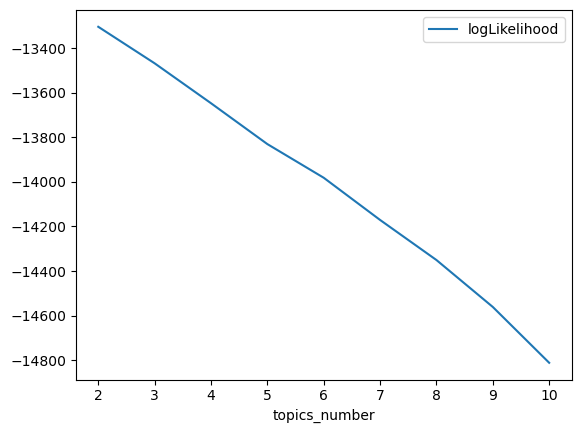

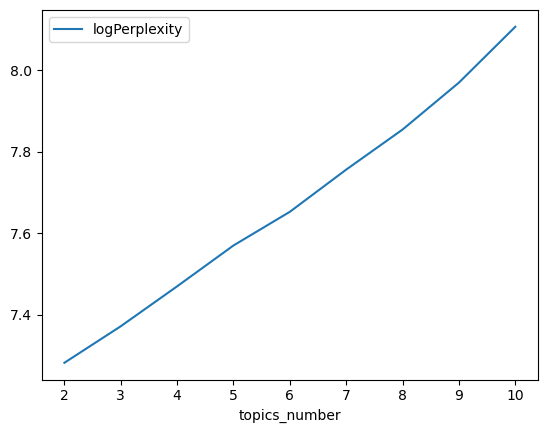

In [9]:
plot_data = pd.DataFrame(list(zip(range(2, 11), log_likelihood, log_perplexity)),
            columns = ['topics_number','logLikelihood','logPerplexity'])    

plot_data.plot(x = 'topics_number', y = 'logLikelihood',kind = 'line')
plt.show()

plot_data.plot(x = 'topics_number', y = 'logPerplexity',kind = 'line')
plt.show()

=> K = 3

In [10]:
lda = LDA(k = 3, maxIter = 100, featuresCol = 'features', seed = 2)
ldaModel = lda.fit(wordVectors_business)
final = ldaModel.transform(wordVectors_business)

In [11]:
vocabulary = vectorizer.vocabulary

topics = ldaModel.describeTopics().collect()

for topic in topics:
    topic_id = topic['topic']
    topic_words_indices = topic['termIndices']
    word_probabilities = topic['termWeights']
    
    topic_words = [vocabulary[idx] for idx in topic_words_indices]
    
    print(f"Topic ID: {topic_id}")
    print("Top Words:")
    for i in range(len(topic_words)):
        word = topic_words[i]
        probability = word_probabilities[i]
        print(f"{word}: {probability}")
    print()

Topic ID: 0
Top Words:
debt: 0.014549611632285533
say: 0.010667492350211479
ceiling: 0.010407236177103036
inflation: 0.009288806542982404
bank: 0.008506241829507665
loan: 0.006649914508010365
chinese: 0.0065579234667317516
may: 0.006217717161429004
china: 0.006214738050536668
end: 0.00613391188521961

Topic ID: 1
Top Words:
business: 0.01870671465003754
us: 0.009375816808700942
billion: 0.008305878242227218
saudi: 0.006679695828388931
sales: 0.0065553243925149775
stock: 0.0060819283158034
build: 0.0058550657289993
account: 0.005709321241151056
bank: 0.005669409907177751
cut: 0.005411429614992764

Topic ID: 2
Top Words:
launch: 0.00829689587495732
new: 0.007182161083261661
market: 0.006792929469155053
year: 0.006558861752878706
better: 0.006168932934272791
rat: 0.006032922702389322
return: 0.005125034461558691
uber: 0.005080976765705983
crisis: 0.004757744850022228
meta: 0.004654344691666162



In [12]:
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
max_index = udf(lambda x: x.index(__builtin__.max(x)) if x is not None else None, IntegerType())
final = final.withColumn('topicDistribution', to_array(final['topicDistribution']))
final = final.withColumn('topic', max_index(final['topicDistribution']))

In [13]:
final.show(10)

+---+--------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
| id|category|        descriptions|  descriptions_words|            filtered|            features|   topicDistribution|topic|
+---+--------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
| 17|Business|Do companies unde...|[do, company, und...|[company, underst...|(1068,[26,156,204...|[0.015769482, 0.0...|    2|
| 21|Business|Five cool project...|[five, cool, proj...|[five, cool, proj...|(1068,[22,54,221,...|[0.017434739, 0.0...|    2|
| 28|Business|Vice Media files ...|[vice, media, fil...|[vice, media, fil...|(1068,[151,309,39...|[0.93583244, 0.03...|    0|
| 35|Business|Wells Fargo reach...|[well, fargo, rea...|[well, fargo, rea...|(1068,[8,128,215,...|[0.019480852, 0.9...|    1|
| 44|Business|Consumer debt pas...|[consumer, debt, ...|[consumer, debt, ...|(1068,[1,20,44,45...|[0.6156066, 0.372...

## For Sci/Tech topic

In [14]:
tech_data = data.filter(col('category') == 'Sci/Tech')
tech_data.count()

1068

In [15]:
preprocessed_tech_df = preprocessing(tech_data, 'descriptions')

vectorizer = CountVectorizer().setInputCol("filtered").setOutputCol("features").fit(preprocessed_tech_df)
wordVectors_tech = vectorizer.transform(preprocessed_tech_df)

In [16]:
wordVectors_tech.show(5)

+---+--------+--------------------+--------------------+--------------------+--------------------+
| id|category|        descriptions|  descriptions_words|            filtered|            features|
+---+--------+--------------------+--------------------+--------------------+--------------------+
|  6|Sci/Tech|Why we need a "Ma...|[why, we, need, a...|[need, manhattan,...|(3229,[79,90,114,...|
|  7|Sci/Tech|Bird Buddy introd...|[bird, buddy, int...|[bird, buddy, int...|(3229,[0,9,349,86...|
| 10|Sci/Tech|TikTok content cr...|[tiktok, content,...|[tiktok, content,...|(3229,[15,18,23,5...|
| 11|Sci/Tech|NASA picks Blue O...|[nasa, pick, blue...|[nasa, pick, blue...|(3229,[7,63,211,2...|
| 14|Sci/Tech|Italy earmarks $M...|[italy, earmark, ...|[italy, earmark, ...|(3229,[0,67,88,11...|
+---+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [17]:
models = []
log_likelihood = []
log_perplexity = []
for num in range(2, 11):
    lda = LDA(k = num, maxIter = 100, featuresCol = 'features', seed = 2)
    ldaModel = lda.fit(wordVectors_tech)
    models.append(ldaModel)
    ll = ldaModel.logLikelihood(wordVectors_tech)
    lp = ldaModel.logPerplexity(wordVectors_tech)
    log_likelihood.append(ll)
    log_perplexity.append(lp)

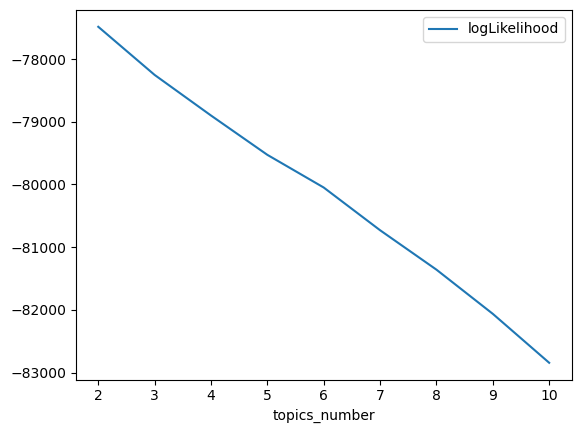

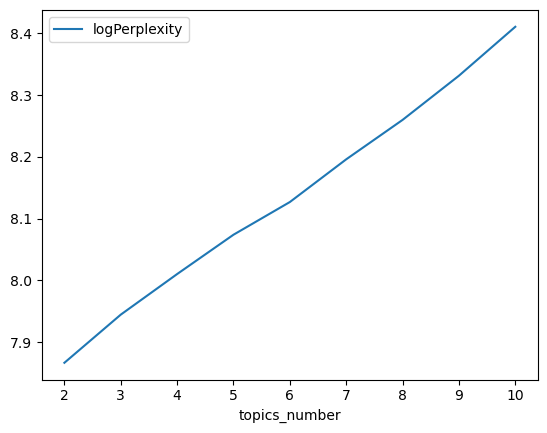

In [18]:
plot_data = pd.DataFrame(list(zip(range(2, 11), log_likelihood, log_perplexity)),
            columns = ['topics_number','logLikelihood','logPerplexity'])    

plot_data.plot(x = 'topics_number', y = 'logLikelihood',kind = 'line')
plt.show()

plot_data.plot(x = 'topics_number', y = 'logPerplexity',kind = 'line')
plt.show()

=> K = 4

In [19]:
lda = LDA(k = 3, maxIter = 100, featuresCol = 'features', seed = 2)
ldaModel = lda.fit(wordVectors_tech)

In [20]:
vocabulary = vectorizer.vocabulary

topics = ldaModel.describeTopics().collect()

for topic in topics:
    topic_id = topic['topic']
    topic_words_indices = topic['termIndices']
    word_probabilities = topic['termWeights']
    
    topic_words = [vocabulary[idx] for idx in topic_words_indices]
    
    print(f"Topic ID: {topic_id}")
    print("Top Words:")
    for i in range(len(topic_words)):
        word = topic_words[i]
        probability = word_probabilities[i]
        print(f"{word}: {probability}")
    print()

Topic ID: 0
Top Words:
ai: 0.018169559978682286
new: 0.013014571121597247
say: 0.010815058952761462
us: 0.008648147786091883
apple: 0.008570571996527792
use: 0.00730357273372425
tech: 0.005549014834306972
make: 0.00537870750251754
chatgpt: 0.005102721201682198
data: 0.004990676466130996

Topic ID: 1
Top Words:
solar: 0.00653722062976365
game: 0.006496085019122467
safety: 0.004757662348881623
production: 0.004740451105286851
ford: 0.003601316083999053
battery: 0.0035490388582752716
account: 0.003490798422866995
m: 0.0034904169559556793
face: 0.003472650819831346
million: 0.003361366416354032

Topic ID: 2
Top Words:
brain: 0.006370944240495818
build: 0.005937156113371638
musk: 0.005337452312638945
elon: 0.005097478473551419
electric: 0.0047394001118419415
power: 0.004513637402286042
come: 0.004510133579164565
drive: 0.004344572807866099
social: 0.004090515198468641
twitter: 0.0039713231037564935



## For Sports topic

In [21]:
sports_data = data.filter(col('category') == 'Sports')
sports_data.count()

287

In [22]:
preprocessed_sports_df = preprocessing(sports_data, 'descriptions')

vectorizer = CountVectorizer().setInputCol("filtered").setOutputCol("features").fit(preprocessed_sports_df)
wordVectors_sports = vectorizer.transform(preprocessed_sports_df)

In [23]:
wordVectors_sports.show(5)

+---+--------+--------------------+--------------------+--------------------+--------------------+
| id|category|        descriptions|  descriptions_words|            filtered|            features|
+---+--------+--------------------+--------------------+--------------------+--------------------+
|  1|  Sports|Josh Harris group...|[josh, harris, gr...|[josh, harris, gr...|(1445,[159,168,30...|
|  3|  Sports|France withdraw f...|[france, withdraw...|[france, withdraw...|(1445,[4,14,15,78...|
| 13|  Sports|Everything for wr...|[everything, for,...|[everything, wres...|(1445,[26,205,383...|
| 18|  Sports|Russia, Belarus h...|[russia, belarus,...|[russia, belarus,...|(1445,[51,118,440...|
| 25|  Sports|Florida Panthers ...|[florida, panther...|[florida, panther...|(1445,[7,11,20,38...|
+---+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [24]:
models = []
log_likelihood = []
log_perplexity = []
for num in range(2, 11):
    lda = LDA(k = num, maxIter = 100, featuresCol = 'features', seed = 2)
    ldaModel = lda.fit(wordVectors_sports)
    models.append(ldaModel)
    ll = ldaModel.logLikelihood(wordVectors_sports)
    lp = ldaModel.logPerplexity(wordVectors_sports)
    log_likelihood.append(ll)
    log_perplexity.append(lp)

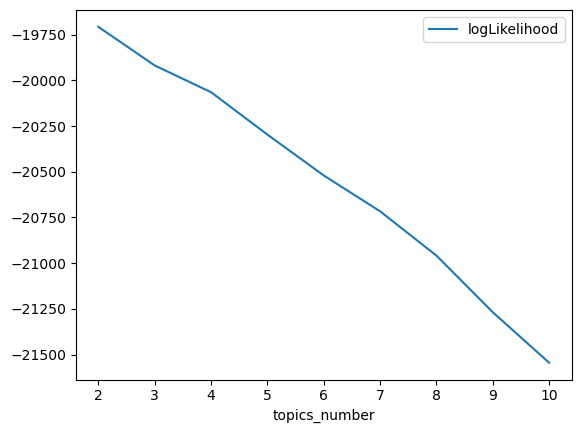

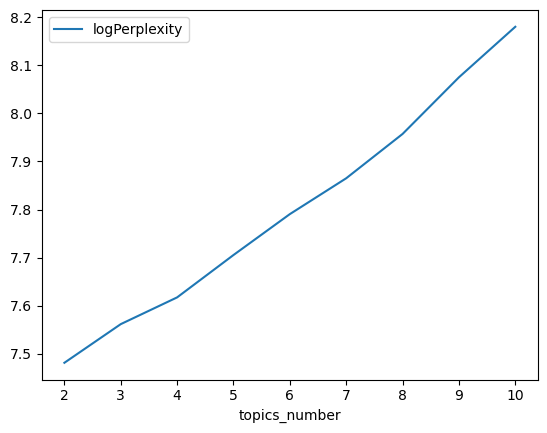

In [25]:
plot_data = pd.DataFrame(list(zip(range(2, 11), log_likelihood, log_perplexity)),
            columns = ['topics_number','logLikelihood','logPerplexity'])    

plot_data.plot(x = 'topics_number', y = 'logLikelihood',kind = 'line')
plt.show()

plot_data.plot(x = 'topics_number', y = 'logPerplexity',kind = 'line')
plt.show()

=> K = 3

In [26]:
lda = LDA(k = 3, maxIter = 100, featuresCol = 'features', seed = 2)
ldaModel = lda.fit(wordVectors_sports)

In [27]:
vocabulary = vectorizer.vocabulary

topics = ldaModel.describeTopics().collect()

for topic in topics:
    topic_id = topic['topic']
    topic_words_indices = topic['termIndices']
    word_probabilities = topic['termWeights']
    
    topic_words = [vocabulary[idx] for idx in topic_words_indices]
    
    print(f"Topic ID: {topic_id}")
    print("Top Words:")
    for i in range(len(topic_words)):
        word = topic_words[i]
        probability = word_probabilities[i]
        print(f"{word}: {probability}")
    print()

Topic ID: 0
Top Words:
win: 0.015369565834927294
game: 0.011928158419970277
final: 0.009992167840837465
league: 0.009632292957795118
championship: 0.007576910211747123
suspend: 0.006432719808855255
cup: 0.005607119068665747
race: 0.005434689603057533
ncaa: 0.005246496818114478
first: 0.004318851352619089

Topic ID: 1
Top Words:
messi: 0.009184854401939464
miami: 0.007903652505323417
inter: 0.007628314621963332
sport: 0.006536964520663355
fan: 0.005447147551267302
million: 0.005435295492692145
lionel: 0.005289743412304935
mill: 0.005011051333287453
record: 0.005009268352261823
team: 0.005007181233049969

Topic ID: 2
Top Words:
open: 0.014792884833720425
french: 0.012543618890099101
say: 0.012090586310201702
rob: 0.0060929569935740165
end: 0.005741907866110942
ja: 0.005464532291399241
former: 0.005139263563143885
court: 0.004997610769628913
burrow: 0.0048807964401769805
sabalenka: 0.004852342990430704



## For World topic

In [28]:
world_data = data.filter(col('category') == 'World')
world_data.count()

2031

In [29]:
preprocessed_world_df = preprocessing(world_data, 'descriptions')

vectorizer = CountVectorizer().setInputCol("filtered").setOutputCol("features").fit(preprocessed_world_df)
wordVectors_world = vectorizer.transform(preprocessed_world_df)

In [30]:
wordVectors_world.show(5)

+---+--------+--------------------+--------------------+--------------------+--------------------+
| id|category|        descriptions|  descriptions_words|            filtered|            features|
+---+--------+--------------------+--------------------+--------------------+--------------------+
|  2|   World|China opposes G m...|[china, oppose, g...|[china, oppose, g...|(4471,[5,32,46,17...|
|  4|   World|Montreal group su...|[montreal, group,...|[montreal, group,...|(4471,[26,33,60,2...|
|  5|   World|Assad shakes hand...|[assad, shake, ha...|[assad, shake, ha...|(4471,[24,336,452...|
|  8|   World|Data indicates fa...|[data, indicate, ...|[data, indicate, ...|(4471,[210,380,42...|
|  9|   World|Bionic technology...|[bionic, technolo...|[bionic, technolo...|(4471,[268,270,45...|
+---+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [31]:
models = []
log_likelihood = []
log_perplexity = []
for num in range(2, 11):
    lda = LDA(k = num, maxIter = 100, featuresCol = 'features')
    ldaModel = lda.fit(wordVectors_world)
    models.append(ldaModel)
    ll = ldaModel.logLikelihood(wordVectors_world)
    lp = ldaModel.logPerplexity(wordVectors_world)
    log_likelihood.append(ll)
    log_perplexity.append(lp)

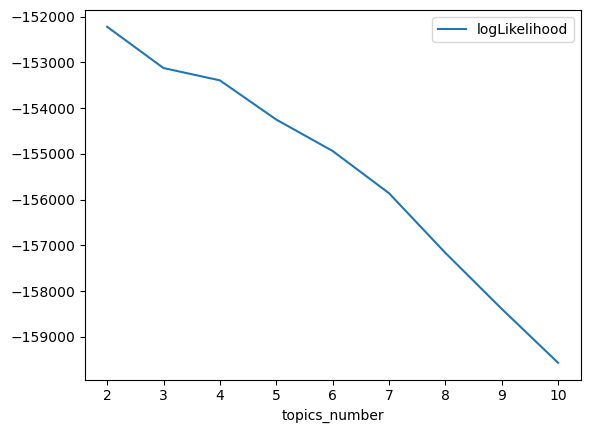

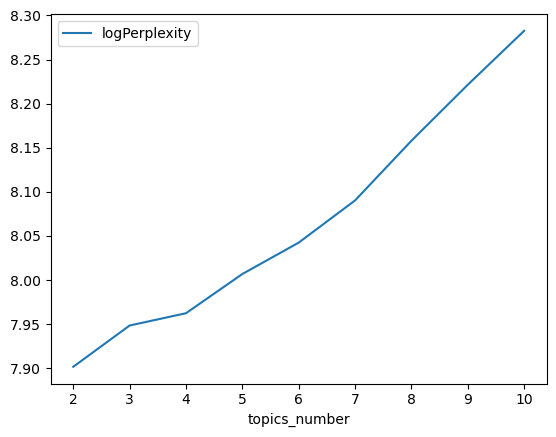

In [32]:
plot_data = pd.DataFrame(list(zip(range(2, 11), log_likelihood, log_perplexity)),
            columns = ['topics_number','logLikelihood','logPerplexity'])    

plot_data.plot(x = 'topics_number', y = 'logLikelihood',kind = 'line')
plt.show()

plot_data.plot(x = 'topics_number', y = 'logPerplexity',kind = 'line')
plt.show()

=> K = 3

In [33]:
lda = LDA(k = 3, maxIter = 100, featuresCol = 'features', seed = 2)
ldaModel = lda.fit(wordVectors_world)

In [34]:
vocabulary = vectorizer.vocabulary

topics = ldaModel.describeTopics().collect()

for topic in topics:
    topic_id = topic['topic']
    topic_words_indices = topic['termIndices']
    word_probabilities = topic['termWeights']
    
    topic_words = [vocabulary[idx] for idx in topic_words_indices]
    
    print(f"Topic ID: {topic_id}")
    print("Top Words:")
    for i in range(len(topic_words)):
        word = topic_words[i]
        probability = word_probabilities[i]
        print(f"{word}: {probability}")
    print()

Topic ID: 0
Top Words:
ukraine: 0.019384668815094704
say: 0.014645300828319892
russia: 0.013979335717543383
russian: 0.010685234797430002
us: 0.009530312320949306
china: 0.008817994591690519
war: 0.005725053337735423
new: 0.005108668860855364
attack: 0.004864554496242734
military: 0.004736678422948545

Topic ID: 1
Top Words:
right: 0.006830814030551338
turkey: 0.006305074813744485
india: 0.0051632047699899705
train: 0.004867564709368863
election: 0.004867295781373676
poland: 0.004655219386283577
people: 0.0045245250123527175
hong: 0.004192652385460941
kong: 0.004187855499326186
iran: 0.004133568341950244

Topic ID: 2
Top Words:
five: 0.004903615299577706
first: 0.004767887174912318
world: 0.004687398479698057
years: 0.004678521545248053
warn: 0.004238894865840598
canada: 0.004122107799913127
spain: 0.003134034002456047
vote: 0.0025392292198142103
amazon: 0.0025006451217014884
doctor: 0.0023770442280997804

